In [1]:
# tensorflow 경고 메세지 무시
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
# clear_output()을 통해 print 했던 로그들을 지우고 새로 출력하게 함
from IPython.display import clear_output 

# # InteractiveShell 옵션에 'all'을 주면 주피터 노트북의 각 셀에서 가장 마지막 줄 뿐만 아니라, 출력하도록 한 모든 값이 출력됨
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

import numpy as np
import pandas as pd

# 높은 이미지 해상도
%config InlineBackend.figure_formats = {'png','retina'}

# pandas 데이터프레임이 너무 긴 경우 가로, 세로 몇 줄까지 보여줄 것인지 설정
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

In [3]:
# Matplotlib을 시각화 모듈로 사용하지만, plot의 기본 스타일은 seaborn의 스타일을 따르도록 한다
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False

# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

# Encoder

In [5]:
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Flatten, Dropout, BatchNormalization, Reshape, LeakyReLU, Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

In [6]:
encoder_input = Input(shape=(100, 100, 3))

# 40 X 40
x = Conv2D(64, 3, padding='same')(encoder_input) 
x = BatchNormalization()(x)
x = LeakyReLU()(x) 

# 40 X 40 -> 20 X 20
x = Conv2D(96, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x) 
x = LeakyReLU()(x) 

# 20 X 20 -> 10 X 10
x = Conv2D(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 10 X 10
x = Conv2D(256, 3, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = Flatten()(x)

encoder_output = Dense(500)(x)

In [7]:
encoder = Model(encoder_input, encoder_output)

In [8]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 64)      256       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100, 100, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 96)        55392     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 96)        384       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 50, 50, 96)        0     

# Decoder

In [8]:
decoder_input = Input(shape=(500, ))

# 2D 좌표를 10*10*64 개의 neuron 출력 값을 가지도록 변경합니다.
x = Dense(25*25*256)(decoder_input)
x = Reshape( (25, 25, 256))(x)

# 10 X 10 -> 10 X 10
x = Conv2DTranspose(256, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 10 X 10 -> 20 X 20
x = Conv2DTranspose(128, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 20 X 20 -> 40 X 40
x = Conv2DTranspose(96, 3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 40 X 40 -> 40 X 40
x = Conv2DTranspose(64, 3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# 최종 output
decoder_output = Conv2DTranspose(3, 3, strides=1, padding='same', activation='tanh')(x)

In [9]:
decoder = Model(decoder_input, decoder_output)

In [11]:
decoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 160000)            80160000  
_________________________________________________________________
reshape (Reshape)            (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 25, 25, 256)       590080    
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 25, 256)       1024      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 25, 25, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 50, 50, 128)       2950

In [10]:
LEARNING_RATE = 0.0005
BATCH_SIZE = 64

In [11]:
encoder_in = Input(shape=(100, 100, 3))
x = encoder(encoder_in)
decoder_out = decoder(x)

# Auto Encoder 모델을 최종 정의

In [12]:
auto_encoder = Model(encoder_in, decoder_out)

In [13]:
auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(LEARNING_RATE), loss=tf.keras.losses.MeanSquaredError())

In [14]:
checkpoint_path = './models/autoencoder_checkpoint100.h5'
checkpoint = ModelCheckpoint(checkpoint_path, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             monitor='val_loss', 
                             verbose=1)

es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=5)

# 데이터

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 모든 이미지를 1/255 스케일로 조정
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = './data/imgs_all'

train_generator = train_datagen.flow_from_directory(
        train_dir, # 타깃 디렉터리
        target_size=(100, 100), # 모든 이미지를 100x100 크기로 변경
        batch_size=BATCH_SIZE,
        class_mode='input',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir, # 타깃 디렉터리
        target_size=(100, 100), # 모든 이미지를 100x100 크기로 변경
        batch_size=BATCH_SIZE,
        class_mode='input',
        subset='validation')

Found 275501 images belonging to 2596 classes.
Found 67650 images belonging to 2596 classes.


In [19]:
hist = auto_encoder.fit(train_generator, 
                        steps_per_epoch = train_generator.samples // BATCH_SIZE, 
                        epochs=100, 
                        callbacks=[checkpoint, es], 
                        validation_data=validation_generator,
                        validation_steps = validation_generator.samples // BATCH_SIZE)

Epoch 1/100
4304/4304 [==============================] - 2231s 517ms/step - loss: 0.0470 - val_loss: 0.0156

Epoch 00001: val_loss improved from inf to 0.01561, saving model to ./models/autoencoder_checkpoint100.h5
Epoch 2/100
4304/4304 [==============================] - 2225s 517ms/step - loss: 0.0138 - val_loss: 0.0133

Epoch 00002: val_loss improved from 0.01561 to 0.01327, saving model to ./models/autoencoder_checkpoint100.h5
Epoch 3/100
4304/4304 [==============================] - 2225s 517ms/step - loss: 0.0114 - val_loss: 0.0130

Epoch 00003: val_loss improved from 0.01327 to 0.01302, saving model to ./models/autoencoder_checkpoint100.h5
Epoch 4/100
4304/4304 [==============================] - 2226s 517ms/step - loss: 0.0105 - val_loss: 0.0125

Epoch 00004: val_loss improved from 0.01302 to 0.01252, saving model to ./models/autoencoder_checkpoint100.h5
Epoch 5/100
4304/4304 [==============================] - 2225s 517ms/step - loss: 0.0099 - val_loss: 0.0123

Epoch 00005: val_lo

Text(0.5, 1.0, 'Training and Test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

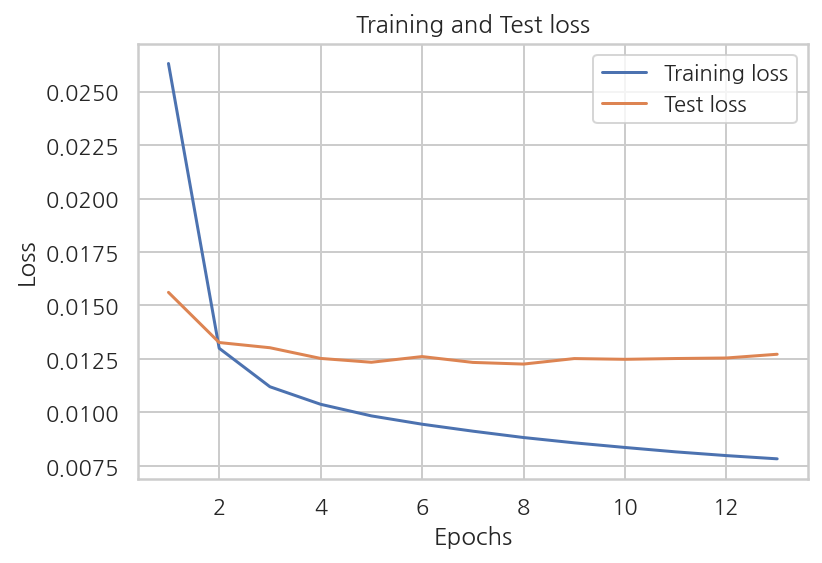

In [20]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs=range(1, len(loss)+1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [19]:
auto_encoder.load_weights(checkpoint_path)

In [22]:
encoder.save('./models/encoder100.h5')

# 시각화

In [20]:
decoded_images = auto_encoder.predict(validation_generator, steps=1, batch_size=15)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


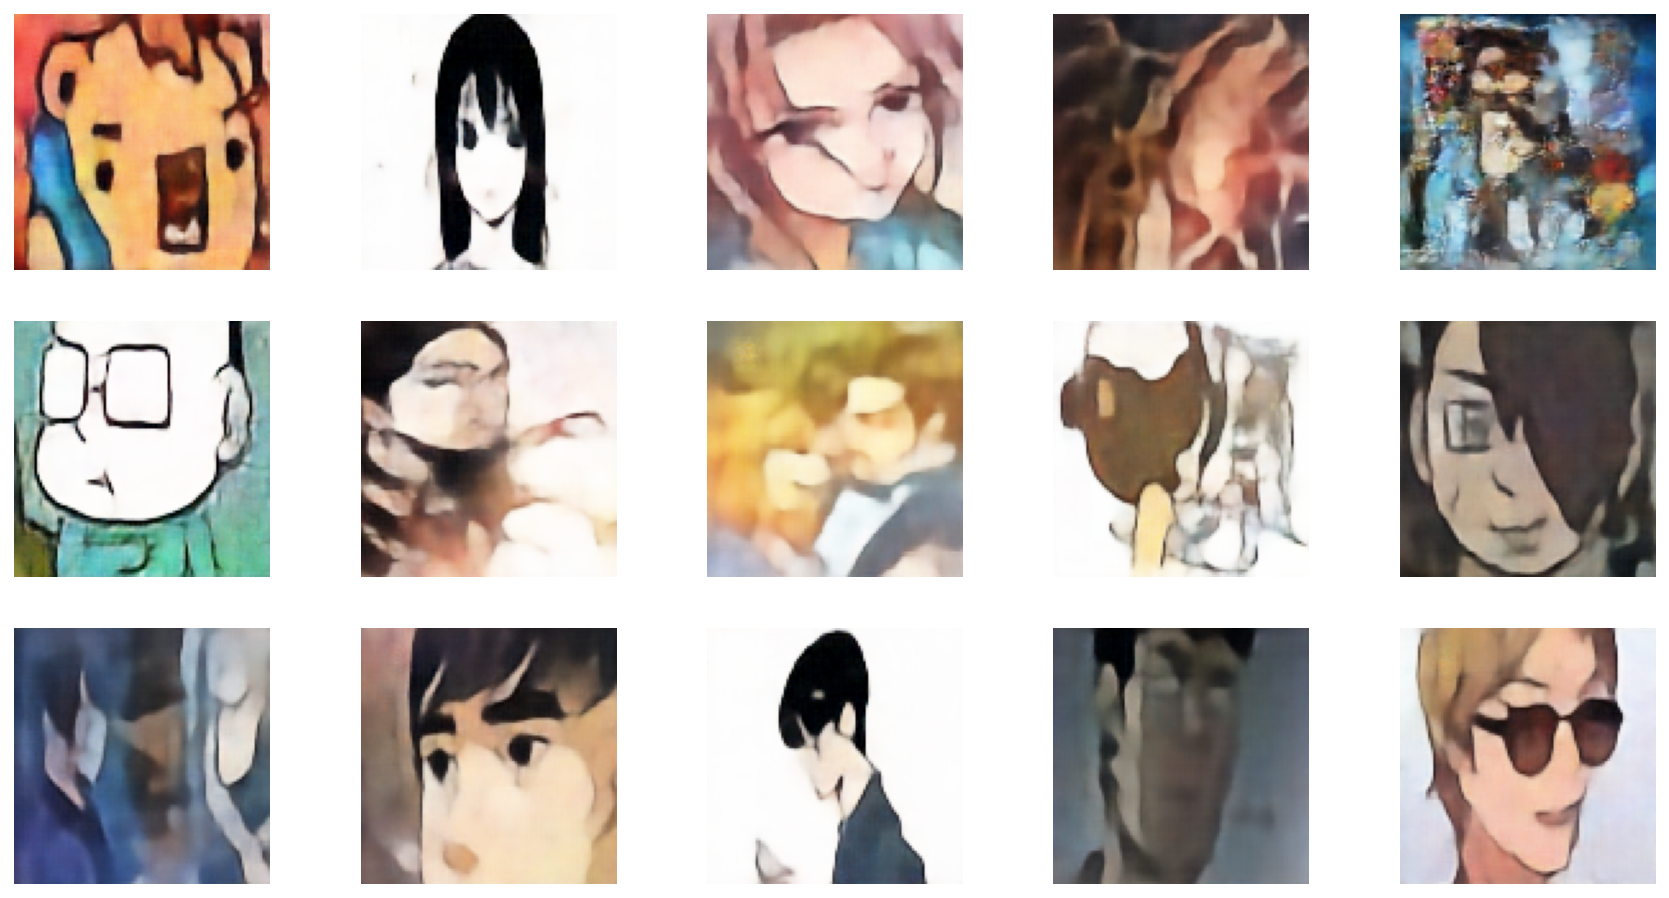

In [22]:
# plt.figure(figsize=(15, 12));
# for i in range(15):
#     plt.subplot(3, 5, i+1);
#     plt.imshow(X_test[i+15]);
#     plt.axis('off');
# plt.show();

plt.figure(figsize=(15, 8))
for i in range(15):
    plt.subplot(3, 5, i+1);
    plt.imshow(decoded_images[i]);
    plt.axis('off');
plt.show();